# Setup

### Import necessary modules and do some basic setup.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pickle
import pathlib
import hashlib
from pathlib import Path
#dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Dotenv
from dotenv import dotenv_values

In [2]:
# Custom utils
from utils.utils_data import *
from utils.utils_plot import *
from utils.utils_RF import *
#from utils.utils_ml import *

### Define some paths and constants.

In [4]:
config = dotenv_values(".env")

# Paths
PATH_ERA5 = config['PATH_ERA5']

# Some constants
G = 9.80665

# Options
DATE_START = '1979-01-01'
DATE_END = '2021-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2021]
LEVELS = [300, 500, 700, 850, 925, 1000]
LONS_INPUT = [-25, 30]
LATS_INPUT = [30, 75]
LONS_PREC = [-25, 30]
LATS_PREC = [30, 75]
BATCH_SIZE = 64
PRECIP_XTRM = 0.95 # Percentile (threshold) for the extremes

In [5]:
# Subsample domain for dev
#LONS_INPUT = [10, 15]
#LATS_INPUT = [40, 45]
#LONS_PREC = [10, 15]
#LATS_PREC = [40, 45]

# Data preparation

## Target variable: precipitation field

In [6]:
# Load precipitation
pr = get_nc_data(PATH_ERA5 + '/precipitation/day_grid1/*nc', DATE_START, DATE_END, LONS_PREC, LATS_PREC)
pr = pr.tp
pr['time'] = pd.DatetimeIndex(pr.time.dt.date)

Extracting data for the period 1979-01-01 - 2021-12-31


In [7]:
# Compute the extreme exceedence
qq = xr.DataArray(pr).chunk(dict(time=-1)).quantile(PRECIP_XTRM, dim='time')
pr_xtrm = xr.DataArray(pr > qq)
pr_xtrm = pr_xtrm*1 # Transform to number

In [8]:
# Extract coordinates for precip
lats_y = pr.lat.to_numpy()
lons_y = pr.lon.to_numpy()

## Input data: meteorological fields

In [9]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # Load geopotential height
    z = get_era5_data(PATH_ERA5 + '/geopotential/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    z['time'] = pd.DatetimeIndex(z.time.dt.date)
    z = z.sel(level=LEVELS)

    # Get Z in geopotential height (m)
    z.z.values = z.z.values/G

    # Load temperature
    t = get_era5_data(PATH_ERA5 + '/temperature/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    t['time'] = pd.DatetimeIndex(t.time.dt.date)

    # Load relative humidity
    rh = get_era5_data(PATH_ERA5 + '/relative_humidity/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    rh['time'] = pd.DatetimeIndex(rh.time.dt.date)
    rh = rh.sel(level=LEVELS)

    # Load total column water
    tcw = get_era5_data(PATH_ERA5 + '/total_column_water/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    tcw['time'] = pd.DatetimeIndex(tcw.time.dt.date)

    # Load wind components
    u = get_era5_data(PATH_ERA5 + '/U_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    u['time'] = pd.DatetimeIndex(u.time.dt.date)
    v = get_era5_data(PATH_ERA5 + '/V_wind/day_grid1/*.nc', DATE_START, DATE_END, LONS_INPUT, LATS_INPUT)
    v['time'] = pd.DatetimeIndex(v.time.dt.date)

# Checking dimensions
print('dimension of pr:', pr.dims)
print('dimension of z', z.dims)
print('dimension of t:', t.dims)
print('dimension of rh:', rh.dims)
print('dimension of tcw:', tcw.dims)
print('dimension of u:', u.dims)
print('dimension of v:', v.dims)


Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
Extracting data for the period 1979-01-01 - 2021-12-31
dimension of pr: ('time', 'lat', 'lon')
dimension of z Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of t: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of rh: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of tcw: Frozen({'time': 15706, 'lon': 56, 'lat': 46})
dimension of u: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})
dimension of v: Frozen({'time': 15706, 'lon': 56, 'lat': 46, 'level': 6})


In [10]:
# Merge arrays
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    X = xr.merge([z, t, rh, tcw, u, v])
X

,Array,Chunk
Bytes,0.90 GiB,21.58 MiB
Shape,"(15706, 6, 46, 56)","(366, 6, 46, 56)"
Count,258 Tasks,43 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,0.90 GiB,21.58 MiB
Shape,"(15706, 6, 46, 56)","(366, 6, 46, 56)"
Count,258 Tasks,43 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [11]:
# Invert lat axis if needed
if X.lat[0].values < X.lat[1].values:
    X = X.reindex(lat=list(reversed(X.lat)))
    
# Get axes
lats_x = X.lat
lons_x = X.lon

### Split data and transform

In [12]:
# Split into training and test
X_train_full = X.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
X_test = X.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

pr_train_full = pr.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
pr_test = pr.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

pr_xtrm_train_full = pr_xtrm.sel(time=slice(f'{YY_TRAIN[0]}-01-01', f'{YY_TRAIN[1]}-12-31'))
pr_xtrm_test = pr_xtrm.sel(time=slice(f'{YY_TEST[0]}-01-01', f'{YY_TEST[1]}-12-31'))

In [13]:
# Create a data generator
dic = {'z': LEVELS,
   't': LEVELS,
   'r': LEVELS,
   'tcwv': None,
   'u': LEVELS,
   'v': LEVELS}

from utils.utils_ml import *

YY_VALID = 2005
# we might not need to split into valid
dg_train = DataGeneratorWithExtremes(X_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     pr_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     pr_xtrm_train_full.sel(time=slice(f'{YY_TRAIN[0]}', f'{YY_VALID}')),
                                     dic, batch_size=BATCH_SIZE, load=True)
dg_valid = DataGeneratorWithExtremes(X_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     pr_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     pr_xtrm_train_full.sel(time=slice(f'{YY_VALID+1}', f'{YY_TRAIN[1]}')),
                                     dic, mean=dg_train.mean, std=dg_train.std,
                                     batch_size=BATCH_SIZE, load=True)
dg_test = DataGeneratorWithExtremes(X_test, pr_test, pr_xtrm_test, dic,
                                    mean=dg_train.mean, std=dg_train.std,
                                    batch_size=BATCH_SIZE, load=True, shuffle=False)


Loading data into RAM
Loading data into RAM
Loading data into RAM


In [14]:
i_shape = dg_train.X.shape
o_shape = dg_train.y.shape

print(f'X shape: {i_shape}')
print(f'y shape: {o_shape}')

X shape: (9862, 46, 56, 31)
y shape: (9862, 46, 56)


In [15]:
chunk = {'lon':5, 'lat':5}

# Train a random forest classifier

In [18]:
X_train_dask = dg_train.X.chunk(chunk)
y_train_dask = dg_train.y_xtrm.chunk(chunk)

In [19]:
# models file
clf_file = 'tmp/trained_classifiers_RF_95th.pkl'

In [20]:
if os.path.isfile(clf_file):
    print('open models')
    #open models
    with open(clf_file, 'rb') as f:
        crfs = pickle.load(f)
else:
    
#%%time
    crfs = xr.apply_ufunc(
        train_rf_classifier_model,
        X_train_dask, y_train_dask,
        vectorize=True,
        dask = 'parallelized',
        input_core_dims=[['time', 'level'], ['time']],  # reduce along these dimensions
        output_dtypes=[object]
    ).compute()
    # save the models
    with open(clf_file, 'wb') as output:
            pickle.dump(crfs, output, pickle.HIGHEST_PROTOCOL)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

### Predict for the testing and training datasets

In [21]:
%%time
y_test_preds = xr.apply_ufunc(
    apply_rf_classifier_model, 
    crfs, dg_test.X,
    vectorize=True,
    input_core_dims=[[],['time', 'level']],
    output_dtypes=['object'] # change the output type
).compute()

CPU times: user 1min 11s, sys: 126 ms, total: 1min 12s
Wall time: 1min 12s


In [22]:
%%time
y_train_preds = xr.apply_ufunc(
    apply_rf_classifier_model, 
    crfs, dg_train.X,
    vectorize=True,
    input_core_dims=[[],['time', 'level']],
    output_dtypes=['object'] # change the output type
).compute()

CPU times: user 3min 15s, sys: 245 ms, total: 3min 16s
Wall time: 3min 16s


In [23]:
# Create Xarray with the predictions

In [24]:
y_pred_xtrm_test = create_xarray_frompred(y_test_preds, lats_y, lons_x)
y_pred_xtrm_train = create_xarray_frompred(y_train_preds, lats_y, lons_x)

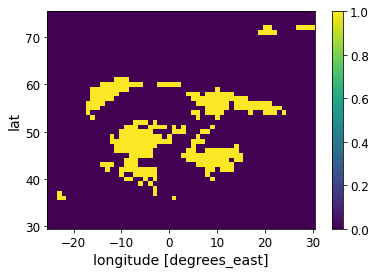

In [26]:
# as an example
y_pred_xtrm_test[800,:,:].plot()

#### Calculate scores (these are also calculated later in the notebook)

In [26]:
%%time
auc = xr.apply_ufunc(
    eval_rf_auc, 
    crfs, dg_test.X,dg_test.y_xtrm,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    output_core_dims=[[]],
    output_dtypes=[float] # change the output type
).compute()

CPU times: user 2min 27s, sys: 147 ms, total: 2min 27s
Wall time: 2min 28s


In [27]:
%%time
precision = xr.apply_ufunc(
    eval_rf_precision, 
    crfs, dg_test.X,dg_test.y_xtrm,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    output_core_dims=[[]],
    output_dtypes=[float] # change the output type
).compute()


CPU times: user 1min 15s, sys: 122 ms, total: 1min 15s
Wall time: 1min 16s


In [28]:
%%time
recall = xr.apply_ufunc(
    eval_rf_recall, 
    crfs, dg_test.X,dg_test.y_xtrm,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    output_core_dims=[[]],
    output_dtypes=[float] # change the output type
).compute()

CPU times: user 1min 15s, sys: 120 ms, total: 1min 15s
Wall time: 1min 16s


In [29]:
# take a look to the results

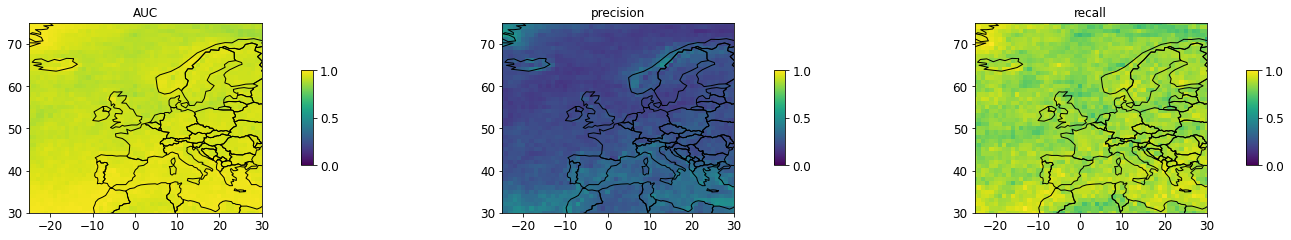

In [30]:
fig, axes = plt.subplots(figsize=(24, 3.5), ncols=3, nrows=1)
plot_map(axes[0], lons_y, lats_y, auc, title="AUC", vmin=0, vmax=1)
plot_map(axes[1], lons_y, lats_y, precision, title="precision", vmin=0, vmax=1)
plot_map(axes[2], lons_y, lats_y, recall, title="recall", vmin=0, vmax=1)

In [31]:
# Metrics-Spatially averages 
metrics_prec_xtrm = pd.DataFrame([(auc.mean().values, recall.mean().values, precision.mean().values)], columns=['auc', 'recall', 'precision'])

In [32]:
print('RF-averages scores:')
print(metrics_prec_xtrm)

RF-averages scores:
                  auc              recall            precision
0  0.9333045621843032  0.8540054366809475  0.26692509135835363


In [33]:
# Reshape predictions to create maps
#preds_reshaped = np.zeros(dg_test.y.shape)

# Train a random forest regressor

In [34]:
# adapt similar functions to the classification case

In [35]:
X_train_dask = dg_train.X.chunk(chunk)
y_train_dask = dg_train.y.chunk(chunk)

In [36]:
# models file
rfs_file = 'tmp/trained_regressors_RF.pkl'

In [37]:
if os.path.isfile(rfs_file):
    print('open models')
    #open models
    with open(rfs_file, 'rb') as f:
        rfs = pickle.load(f)
else:
    
    rfs = xr.apply_ufunc(
        train_rf_regress_model,
        X_train_dask, y_train_dask,
        vectorize=True,
        dask = 'parallelized',
        input_core_dims=[['time', 'level'], ['time']],  # reduce along these dimensions
        output_dtypes=[object]
    ).compute()
    # save the models
    with open('tmp/trained_regressors_RF.pkl', 'wb') as output:
            pickle.dump(rfs, output, pickle.HIGHEST_PROTOCOL)

open models


In [44]:
# calculate predictions
y_test_preds_reg = xr.apply_ufunc(
    apply_rf_regress_model, 
    rfs, dg_test.X,
    vectorize=True,
    input_core_dims=[[],['time', 'level']],
    output_core_dims=[[]],
    output_dtypes=[object] # change the output type
).compute()

In [45]:
# calculate predictions
y_train_preds_reg = xr.apply_ufunc(
    apply_rf_regress_model, 
    rfs, dg_train.X,
    vectorize=True,
    input_core_dims=[[],['time', 'level']],
    output_core_dims=[[]],
    output_dtypes=[object] # change the output type
).compute()

In [46]:
# Create matrix of predictions
preds_test_reg_matrix = create_xarray_frompred(y_test_preds_reg, lats_y, lons_x)
preds_train_reg_matrix = create_xarray_frompred(y_train_preds_reg, lats_y, lons_x)

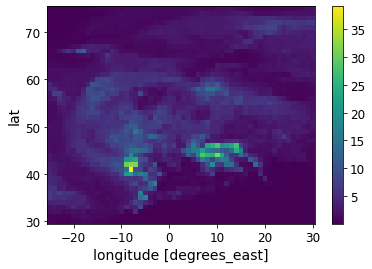

In [41]:
preds_test_reg_matrix[800,:,:].plot()

#### calculate rmse

In [42]:
#evaluate--check --not working
rmse = xr.apply_ufunc(
    eval_rf_mse, 
    rfs, dg_test.X,dg_test.y,
    vectorize=True,
    input_core_dims=[[],['time', 'level'],['time']],
    #output_core_dims=[[]],
   # output_dtypes=[object] # change the output type
).compute()

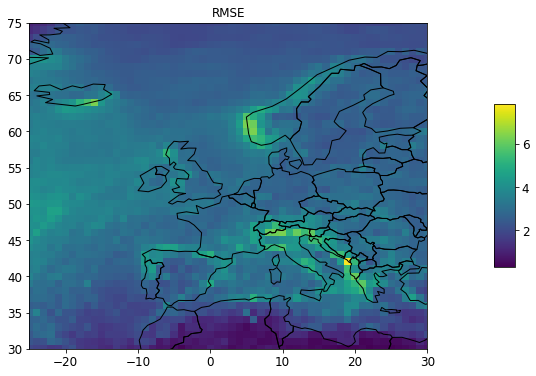

In [43]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=1, nrows=1)
plot_map(axes, lons_y, lats_y, rmse, title="RMSE")

In [44]:
# Spatial average of MSE
# Metrics-Spatially averages 
rmse.mean().values

array(2.80361526)

# Predict and assess on the test period

In [47]:
def analyze_predictions(y_pred, dg, qq, pred_xtrm=False, show_plots=True, plot_most_extreme=True, plot_worst_best=False, plot_scores=True, plot_confusion_components=True):
    if pred_xtrm:
        print("exreme")
       # y_pred_bool = y_pred >= 0.5
        y_pred_bool = y_pred  #no need
    else:
        print("non extremes")
        y_pred_bool = y_pred > qq.to_numpy().squeeze()
        
    # Multiply to transorm to numeric values
    y_pred_bool = y_pred_bool * 1
    
    # Extract true values
    
    y_xtrm = dg.y_xtrm.to_numpy().squeeze()
    y_prec = dg.y.to_numpy().squeeze()
    
   
    # Get the index of the max # of extremes
    i_max_obs = np.argmax(np.sum(y_xtrm, axis=(1,2)))
  
    if show_plots and plot_most_extreme:
        
        if pred_xtrm:
            print("plot")
            fig, axes = plt.subplots(figsize=(12, 3.5), ncols=2, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_max_obs], title="Day with max # extremes - truth (xtrm)", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_max_obs], title="Day with max # extremes - prediction (prob xtrm)", vmin=0, vmax=1)
        else:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            vmax = max(np.max(y_prec[i_max_obs]), np.max(y_pred[i_max_obs]))
            plot_map(axes[0], lons_y, lats_y, y_prec[i_max_obs], title="Day with max # extremes - truth (val)", vmin=0, vmax=vmax)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_max_obs], title="Day with max # extremes - prediction (val)", vmin=0, vmax=vmax)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_max_obs], title="Day with max # extremes - truth (xtrm)", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred_bool[i_max_obs], title="Day with max # extremes - prediction (xtrm)", vmin=0, vmax=1)
        
    # Get the index of the max/min difference between prediction and obs
    y_diffs_series = np.sum(np.absolute(y_xtrm - y_pred_bool), axis=(1,2))
   # i_worst_pred = np.argmax(y_diffs_series)
    i_worst_pred = np.argmax(np.array(y_diffs_series)) # convert to array
    i_best_pred = np.argmin(np.array(y_diffs_series))
    
    if show_plots and plot_worst_best:
        
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_worst_pred], title="Worst prediction - truth", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred[i_worst_pred], title="Worst prediction - prediction", vmin=0, vmax=1)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_best_pred], title="Best prediction - truth", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred[i_best_pred], title="Best prediction - prediction", vmin=0, vmax=1)
        else:
            fig, axes = plt.subplots(figsize=(24, 3.5), ncols=4, nrows=1)
            plot_map(axes[0], lons_y, lats_y, y_xtrm[i_worst_pred], title="Worst prediction - truth", vmin=0, vmax=1)
            plot_map(axes[1], lons_y, lats_y, y_pred_bool[i_worst_pred], title="Worst prediction - prediction", vmin=0, vmax=1)
            plot_map(axes[2], lons_y, lats_y, y_xtrm[i_best_pred], title="Best prediction - truth", vmin=0, vmax=1)
            plot_map(axes[3], lons_y, lats_y, y_pred_bool[i_best_pred], title="Best prediction - prediction", vmin=0, vmax=1)
    
    # Compute scores
    
    precision, recall = eval_confusion_matrix_scores_on_map(y_xtrm, y_pred_bool)
    
    if pred_xtrm:
        print("get scores")
        roc_auc = eval_roc_auc_score_on_map(y_xtrm, y_pred)
    if not pred_xtrm:
        MSE = np.square(np.subtract(y_prec,y_pred)).mean() 
        rmse = sqrt(MSE)
        
    if show_plots and plot_scores:
        if pred_xtrm:
            fig, axes = plt.subplots(figsize=(18, 4), ncols=3, nrows=1)
        else:
            fig, axes = plt.subplots(figsize=(12, 4), ncols=2, nrows=1)

        plot_map(axes[0], lons_y, lats_y, precision, title="Precision", vmin=0, vmax=1)
        plot_map(axes[1], lons_y, lats_y, recall, title="Recall", vmin=0, vmax=1)
        if pred_xtrm:
            plot_map(axes[2], lons_y, lats_y, roc_auc, title="ROC AUC", vmin=0.5, vmax=1)

    if show_plots and plot_confusion_components:
        tn, fp, fn, tp = eval_confusion_matrix_on_map(y_xtrm, y_pred_bool)
        fig, axes = plt.subplots(figsize=(24, 4), ncols=4, nrows=1)
        plot_map(axes[0], lons_y, lats_y, tn, title="True negative")
        plot_map(axes[1], lons_y, lats_y, fp, title="False positive")
        plot_map(axes[2], lons_y, lats_y, fn, title="False negative")
        plot_map(axes[3], lons_y, lats_y, tp, title="True positive")
    
    plt.show()
    
    if pred_xtrm:
        print("return scores")
        return np.mean(precision), np.mean(recall), np.mean(roc_auc)
    
    return np.mean(precision), np.mean(recall), np.mean(rmse)

In [48]:
# Predict the amount of precipitation
df_prec = pd.DataFrame(columns = ['id', 'name',
                                  'train_pr_rmse', 'test_pr_rmse', 
                                  'train_xtrm_precision', 'test_xtrm_precision', 
                                  'train_xtrm_recall', 'test_xtrm_recall'],index=[1])
df_prec.at[df_prec.index[0], 'id'] = 'RF'
df_prec.at[df_prec.index[0], 'name'] = 'Regressor'
df_xtrm = pd.DataFrame(columns = ['id', 'name', 
                                  'train_xtrm_roc_auc', 'test_xtrm_roc_auc', 
                                  'train_xtrm_precision', 'test_xtrm_precision', 
                                  'train_xtrm_recall', 'test_xtrm_recall'],index=[1])
df_xtrm.at[df_xtrm.index[0], 'id'] = 'RF'
df_xtrm.at[df_xtrm.index[0], 'name'] = 'Classifier'

In [49]:
### Result for precipitation amounts, training and testing

In [50]:
apply_for_prec = True

if apply_for_prec:
    print('Train results')
    precision_train, recall_train, rmse_train = analyze_predictions(preds_train_reg_matrix, dg_train, qq, pred_xtrm=False, show_plots=False)
    df_prec.at[df_prec.index[0], 'train_xtrm_precision'] = precision_train
    df_prec.at[df_prec.index[0], 'train_xtrm_recall'] = recall_train
    df_prec.at[df_prec.index[0], 'train_pr_rmse'] = rmse_train
    print('Test results')
    precision, recall, rmse = analyze_predictions(preds_test_reg_matrix, dg_test, qq, pred_xtrm=False, show_plots=False)
    df_prec.at[df_prec.index[0], 'test_xtrm_precision'] = precision
    df_prec.at[df_prec.index[0], 'test_xtrm_recall'] = recall
    df_prec.at[df_prec.index[0], 'test_pr_rmse'] = rmse
 

Train results
non extremes
Test results
non extremes


In [51]:
df_prec

,id,name,train_pr_rmse,test_pr_rmse,train_xtrm_precision,test_xtrm_precision,train_xtrm_recall,test_xtrm_recall
1,RF,Regressor,2.665529,2.931869,0.734014,0.659316,0.274894,0.234968


In [52]:
### Result for precipitation extremes, training and testing

In [53]:
apply_for_xtrm = True

if apply_for_xtrm:
    print('Train results')
    precision_train, recall_train, auc_train = analyze_predictions(y_pred_xtrm_train, dg_train, qq, pred_xtrm=True, show_plots=False)
    df_xtrm.at[df_xtrm.index[-1], 'train_xtrm_precision'] = precision_train
    df_xtrm.at[df_xtrm.index[-1], 'train_xtrm_recall'] = recall_train
    df_xtrm.at[df_xtrm.index[-1], 'train_xtrm_roc_auc'] = auc_train

    print('Test results')
    precision, recall, auc = analyze_predictions(y_pred_xtrm_test, dg_test, qq, pred_xtrm=True, show_plots=False)
    df_xtrm.at[df_xtrm.index[-1], 'test_xtrm_precision'] = precision
    df_xtrm.at[df_xtrm.index[-1], 'test_xtrm_recall'] = recall
    df_xtrm.at[df_xtrm.index[-1], 'test_xtrm_roc_auc'] = auc
    

Train results
exreme
get scores
return scores
Test results
exreme
get scores
return scores


In [54]:
df_xtrm

,id,name,train_xtrm_roc_auc,test_xtrm_roc_auc,train_xtrm_precision,test_xtrm_precision,train_xtrm_recall,test_xtrm_recall
1,RF,Classifier,0.895929,0.859132,0.268384,0.266925,0.93134,0.854005
